In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv('/content/PRSA_Data_Aotizhongxin_20130301-20170228.csv')

# Clean and rename columns
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={'pm2.5': 'pm2_5'}, inplace=True)

# Create datetime index
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Select features
features = ['pm2_5', 'temp', 'pres', 'dewp', 'wspm']
df_model = df[features].dropna()

In [2]:
df.head()

,no,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wd,wspm,station
datetime,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
2013-03-01 01:00:00,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2013-03-01 02:00:00,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
2013-03-01 03:00:00,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
2013-03-01 04:00:00,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [3]:
# Normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_model)

# Build sequences of 24 hours
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 0])  # PM2.5 is first column
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [4]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0030 - val_loss: 8.7187e-04
Epoch 2/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 9.2209e-04 - val_loss: 4.8792e-04
Epoch 3/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 6.6108e-04 - val_loss: 5.3619e-04
Epoch 4/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 6.0119e-04 - val_loss: 4.1550e-04
Epoch 5/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 5.9284e-04 - val_loss: 3.9910e-04
Epoch 6/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5.9445e-04 - val_loss: 4.4656e-04
Epoch 7/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 6.0128e-04 - val_loss: 6.3111e-04
Epoch 8/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5.8041e-04 - val_loss: 4.3902e-04
Epoch 9/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.7770e-04 - val_loss: 4.1353e-04
Epoch 10/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 6.0994e-04 - val_loss: 4.3656e-04


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,725 (1.40 MB)

 Trainable params: 122,241 (477.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,484 (955.02 KB)

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM R²: 0.9550950351930378
LSTM MSE: 0.050062499531419946


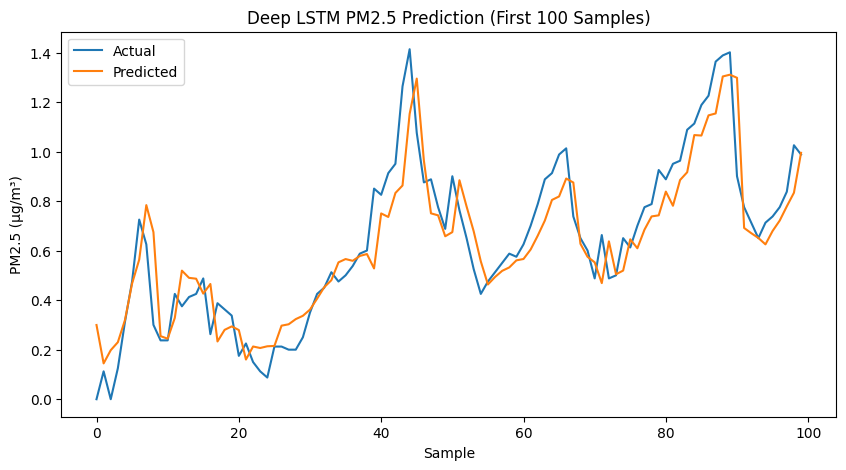

In [5]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform predictions and labels
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, 1:], y_test.reshape(-1,1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, -1, 1:], y_pred), axis=1))[:, -1]

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
print("LSTM R²:", r2_score(y_test_inv, y_pred_inv))
print("LSTM MSE:", mean_squared_error(y_test_inv, y_pred_inv))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='Predicted')
plt.title("Deep LSTM PM2.5 Prediction (First 100 Samples)")
plt.xlabel("Sample")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()


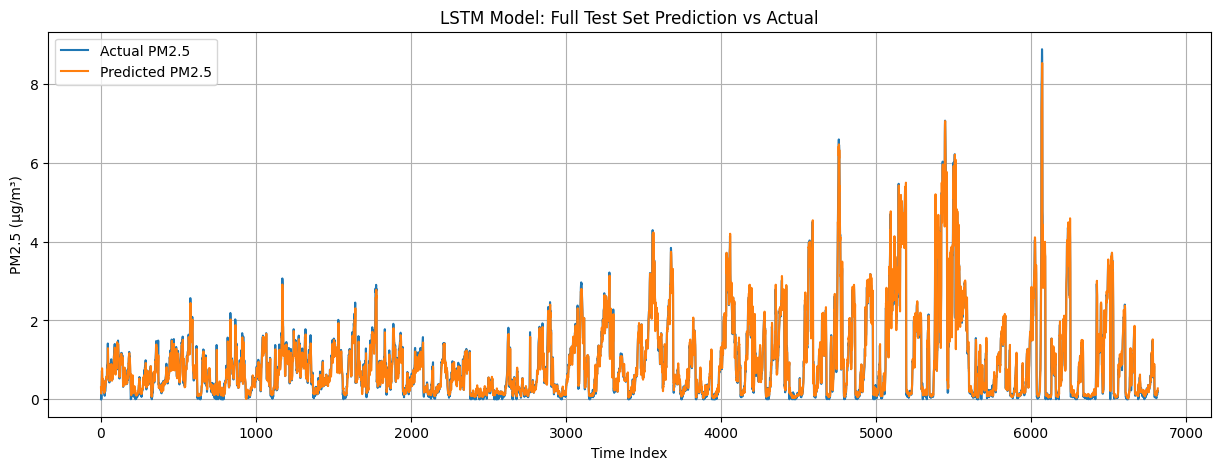

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Actual PM2.5')
plt.plot(y_pred_inv, label='Predicted PM2.5')
plt.title('LSTM Model: Full Test Set Prediction vs Actual')
plt.xlabel('Time Index')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()


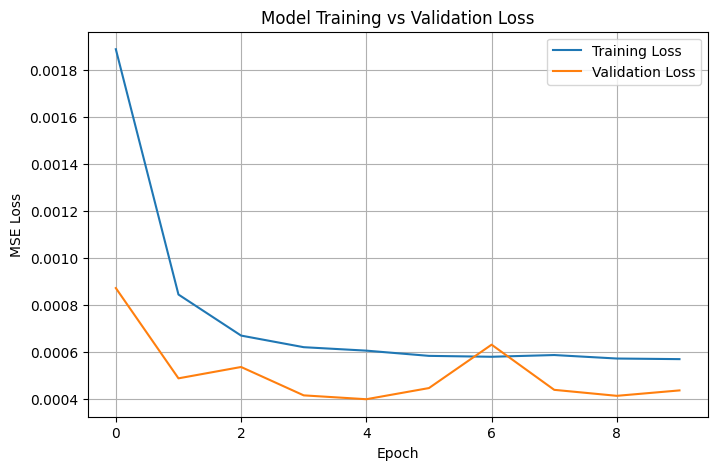

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


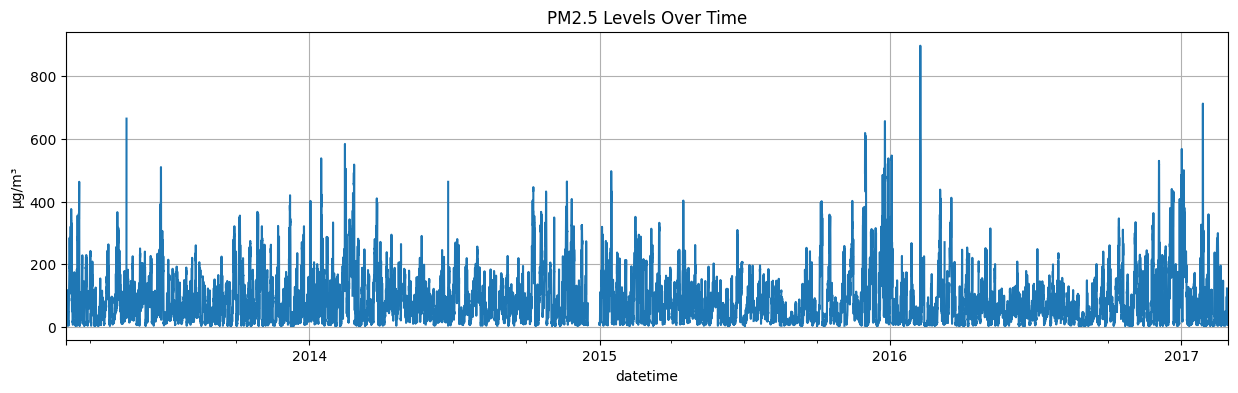

In [12]:
df['pm2_5'].plot(figsize=(15,4), title='PM2.5 Levels Over Time', ylabel='µg/m³')
plt.grid(True)
plt.show()


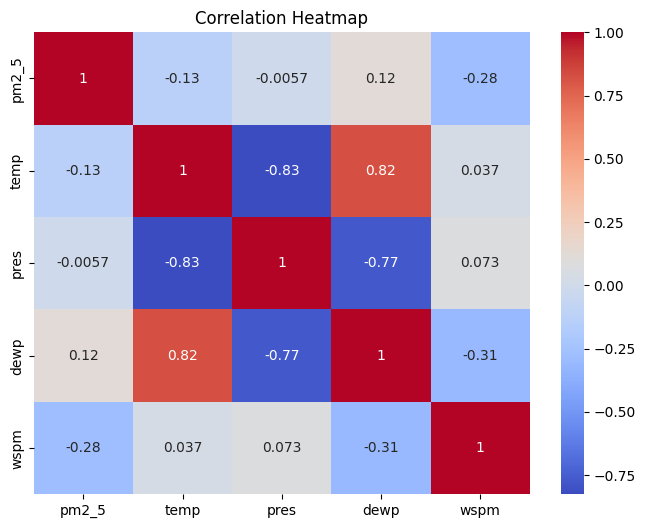

In [9]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


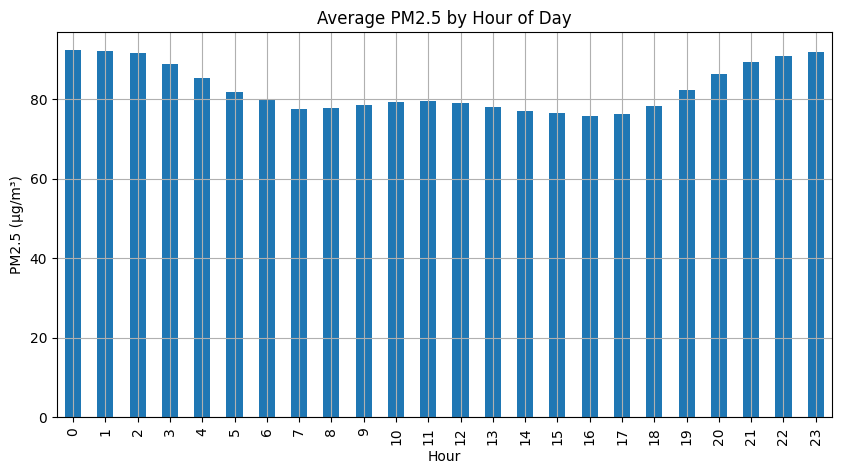

In [11]:
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['pm2_5'].mean()

plt.figure(figsize=(10,5))
hourly_avg.plot(kind='bar')
plt.title('Average PM2.5 by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.show()
